In [1]:
%pip install --quiet \
    --upgrade \
    networkx \
    osmnx \
    matplotlib \
    scipy

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# Dijkstra

In [3]:
def dijkstrasAlgorithmWithPaths(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting node to all other nodes in a graph.
    Additionally, it tracks the path to each node using a predecessor list.

    Args:
        start (int): The starting node index.
        edges (list of list): Adjacency list representing the graph. Each index corresponds to a vertex,
                              and each entry is a list of pairs [destination, weight].

    Returns:
        tuple: A tuple containing:
            - minDistances (list): A list of the shortest distances from the starting node to each node.
                                   If a node is unreachable, its distance is `inf`.
            - previousNodes (list): A list where each index points to the predecessor of the node
                                    in the shortest path. `None` if no path exists.
    """
    numberOfVertices = len(edges)

    # Initialize the minimum distances with infinity, except for the starting node (distance 0).
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Set of visited nodes to avoid re-processing.
    visited = set()

    # Predecessor list to track the path to each node.
    previousNodes = [None] * numberOfVertices

    # Iterate until all nodes are processed or no more reachable nodes exist.
    while len(visited) != numberOfVertices:
        # Find the unvisited node with the smallest known distance.
        vertex, currentMinDistance = getVertexWithMinDistance(minDistances, visited)

        # If the smallest distance is infinity, remaining nodes are unreachable.
        if currentMinDistance == float("inf"):
            break

        # Mark the current node as visited.
        visited.add(vertex)

        # Update distances for all neighbors of the current node.
        for edge in edges[vertex]:
            destination, distanceToDestination = edge

            # Skip if the neighbor is already visited.
            if destination in visited:
                continue

            # Calculate the new potential path distance.
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # Update the shortest distance and the predecessor if the new path is shorter.
            if newPathDistance <= currentDestinationDistance:
                minDistances[destination] = newPathDistance
                previousNodes[destination] = vertex  # Update predecessor

    return minDistances, previousNodes


def getVertexWithMinDistance(distances, visited):
    """
    Helper function to find the unvisited node with the smallest known distance.

    Args:
        distances (list): A list of the shortest known distances to each node.
        visited (set): A set of already visited nodes.

    Returns:
        tuple: The index of the node with the smallest distance and its distance value.
    """
    currentMinDistance = float("inf")
    vertex = -1

    # Iterate over all nodes to find the one with the smallest distance.
    for vertexIdx, distance in enumerate(distances):
        if vertexIdx in visited:
            continue
        if distance <= currentMinDistance:
            vertex = vertexIdx
            currentMinDistance = distance

    return vertex, currentMinDistance

# Dijkstra MinHeap

In [4]:
class MinHeap:
    """
    MinHeap class: Implements a MinHeap data structure to efficiently manage vertices and their distances
    for algorithms like Dijkstra. This implementation keeps track of the position of each vertex using
    a vertex map for constant-time lookups and updates.
    """
    def __init__(self, array):
        """
        Initializes the MinHeap with an input array of (vertex, distance) pairs.

        Args:
            array (list): List of tuples where each tuple is (vertex, distance).
                          The distance is typically initialized to infinity except for the starting vertex.

        Attributes:
            vertexMap (dict): Maps each vertex to its position in the heap for quick access.
            heap (list): List representing the binary heap as an array.
        """
        # Create a vertex map: Maps vertices to their indices in the heap.
        self.vertexMap = {idx: idx for idx in range(len(array))}

        # Build the heap from the input array to satisfy the heap property.
        self.heap = self.buildHeap(array)

    def isEmpty(self):
        """
        Checks if the heap is empty.

        Returns:
            bool: True if the heap is empty, False otherwise.
        """
        return len(self.heap) == 0

    def buildHeap(self, array):
        """
        Builds the heap from an input array in O(n) time.

        Args:
            array (list): List of (vertex, distance) pairs.

        Returns:
            list: The input array transformed into a valid MinHeap.
        """
        # Start from the first parent node and sift down each node.
        firstParentIdx = (len(array) - 2) // 2
        for currentIdx in reversed(range(firstParentIdx + 1)):
            self.siftDown(currentIdx, len(array) - 1, array)
        return array

    def siftDown(self, currentIdx, endIdx, heap):
        """
        Restores the heap property by "sifting down" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift down.
            endIdx (int): Last index in the heap.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        childOneIdx = currentIdx * 2 + 1  # Index of the first child
        while childOneIdx <= endIdx:
            # Determine the index of the second child
            childTwoIdx = currentIdx * 2 + 2 if currentIdx * 2 + 2 <= endIdx else -1

            # Choose the smaller child to maintain the min-heap property
            if childTwoIdx != -1 and heap[childTwoIdx][1] < heap[childOneIdx][1]:
                idxToSwap = childTwoIdx
            else:
                idxToSwap = childOneIdx

            # Swap if the child is smaller than the current node
            if heap[idxToSwap][1] < heap[currentIdx][1]:
                self.swap(currentIdx, idxToSwap, heap)
                currentIdx = idxToSwap  # Move to the swapped position
                childOneIdx = currentIdx * 2 + 1  # Update the first child index
            else:
                return

    def siftUp(self, currentIdx, heap):
        """
        Restores the heap property by "sifting up" a node into its correct position.

        Args:
            currentIdx (int): Index of the node to sift up.
            heap (list): The heap array.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        parentIdx = (currentIdx - 1) // 2  # Calculate parent index
        while currentIdx > 0 and heap[currentIdx][1] < heap[parentIdx][1]:
            self.swap(currentIdx, parentIdx, heap)  # Swap with parent
            currentIdx = parentIdx  # Move to the parent's position
            parentIdx = (currentIdx - 1) // 2

    def remove(self):
        """
        Removes and returns the smallest element (root) in the heap.

        Returns:
            tuple: The (vertex, distance) pair with the smallest distance.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        if self.isEmpty():
            return None

        # Swap the root with the last element and remove it
        self.swap(0, len(self.heap) - 1, self.heap)
        vertex, distance = self.heap.pop()
        self.vertexMap.pop(vertex)  # Remove the vertex from the map

        # Restore the heap property
        self.siftDown(0, len(self.heap) - 1, self.heap)
        return vertex, distance

    def swap(self, i, j, heap):
        """
        Swaps two nodes in the heap and updates their positions in the vertexMap.

        Args:
            i (int): Index of the first node.
            j (int): Index of the second node.
            heap (list): The heap array.
        """
        self.vertexMap[heap[i][0]] = j  # Update vertexMap for heap[i]
        self.vertexMap[heap[j][0]] = i  # Update vertexMap for heap[j]
        heap[i], heap[j] = heap[j], heap[i]  # Swap the nodes in the heap

    def update(self, vertex, value):
        """
        Updates the distance of a given vertex and restores the heap property.

        Args:
            vertex (int): The vertex whose distance is to be updated.
            value (int): The new distance value.

        Complexity:
            Time: O(log(n))
            Space: O(1)
        """
        # Update the heap with the new (vertex, value) pair
        self.heap[self.vertexMap[vertex]] = (vertex, value)
        # Restore the heap property by sifting up the updated node
        self.siftUp(self.vertexMap[vertex], self.heap)

In [5]:
# O((v + e) * log(v)) time | O(v) space — where v is the number
# of vertices and e is the number of edges in the input graph
def dijkstrasAlgorithm(start, edges):
    """
    Implements Dijkstra's algorithm to find the shortest paths from a starting vertex to all other vertices
    in a weighted graph. The graph is represented using an adjacency list.

    Args:
        start (int): The starting vertex index.
        edges (list of list): An adjacency list where each index represents a vertex, and each entry
                              is a list of [destination, weight] pairs.

    Returns:
        list: A list of minimum distances from the starting vertex to each vertex in the graph.
              If a vertex is unreachable, its distance is represented as -1.
    """
    # Step 1: Initialize the number of vertices in the graph
    numberOfVertices = len(edges)

    # Step 2: Initialize the minimum distances with infinity
    # Set the starting vertex's distance to 0
    minDistances = [float("inf") for _ in range(numberOfVertices)]
    minDistances[start] = 0

    # Step 3: Initialize the MinHeap to track the vertices and their current shortest distances
    minDistancesHeap = MinHeap([(idx, float("inf")) for idx in range(numberOfVertices)])
    minDistancesHeap.update(start, 0)  # Update the starting vertex's distance to 0

    # Step 4: Process vertices until the heap is empty
    while not minDistancesHeap.isEmpty():
        # Extract the vertex with the smallest known distance
        vertex, currentMinDistance = minDistancesHeap.remove()

        # If the current distance is infinity, no further reachable vertices exist
        if currentMinDistance == float("inf"):
            break

        # Step 5: Relaxation - Update distances for all neighboring vertices
        for edge in edges[vertex]:
            destination, distanceToDestination = edge  # Extract neighbor and weight

            # Calculate the new potential path distance
            newPathDistance = currentMinDistance + distanceToDestination
            currentDestinationDistance = minDistances[destination]

            # If the new path is shorter, update the distance and the heap
            if newPathDistance < currentDestinationDistance:
                minDistances[destination] = newPathDistance
                minDistancesHeap.update(destination, newPathDistance)

    # Step 6: Convert unreachable vertices' distances from infinity to -1
    return list(map(lambda x: -1 if x == float("inf") else x, minDistances))

In [6]:
def test_dijkstras_algorithm():
    """
    Test function for Dijkstra's algorithm.

    This test evaluates the correctness of the `dijkstrasAlgorithm` function using a predefined input graph
    and expected output. The graph is represented as an adjacency list, and the test ensures that the
    algorithm computes the shortest paths correctly.

    Input Graph:
        Node 0 -> Node 1 (weight 7)
        Node 1 -> Node 2 (weight 6), Node 3 (weight 20), Node 4 (weight 3)
        Node 2 -> Node 3 (weight 14)
        Node 3 -> Node 4 (weight 2)
        Node 4 -> No outgoing edges
        Node 5 -> No outgoing edges

    Expected Output:
        [0, 7, 13, 27, 10, -1]
        - Shortest distances from node 0 to all other nodes.
        - `-1` represents unreachable nodes (node 5 in this case).

    Assertions:
        The test checks if the result matches the expected output and raises an assertion error otherwise.

    Returns:
        None. Prints "Test passed" if the output is correct.
    """
    # Input graph represented as an adjacency list
    edges = [
        [[1, 7]],                   # Node 0 -> Node 1 (weight 7)
        [[2, 6], [3, 20], [4, 3]],  # Node 1 -> Node 2 (6), Node 3 (20), Node 4 (3)
        [[3, 14]],                  # Node 2 -> Node 3 (weight 14)
        [[4, 2]],                   # Node 3 -> Node 4 (weight 2)
        [],                         # Node 4 has no outgoing edges
        []                          # Node 5 has no outgoing edges
    ]
    start = 0  # Starting node for Dijkstra's algorithm

    # Expected output: Shortest distances from the starting node
    expected_output = [0, 7, 13, 27, 10, -1]

    # Step 1: Run Dijkstra's algorithm on the input graph
    result = dijkstrasAlgorithm(start, edges)

    # Step 2: Compare the result with the expected output
    assert result == expected_output, f"Test failed: expected {expected_output}, but got {result}"

    # Step 3: If no assertion error, print test success message
    print("Test passed: Output matches expected result.")


# Run the test function
test_dijkstras_algorithm()

Test passed: Output matches expected result.


In [7]:
# def dijkstrasAlgorithmWithPaths(start, edges):
#     """
#     Implements Dijkstra's algorithm to compute the shortest paths from a starting vertex to all other vertices
#     in a weighted graph. It also tracks the predecessors of each vertex for path reconstruction.

#     Args:
#         start (int): The index of the starting vertex.
#         edges (list of list): Adjacency list representation of the graph, where each index represents a vertex,
#                               and each entry is a list of [destination, weight] pairs.

#     Returns:
#         tuple: A tuple containing:
#             - minDistances (list): A list of the shortest distances from the starting vertex to each vertex.
#                                    Vertices that are unreachable will have a distance of `float("inf")`.
#             - previousNodes (list): A list where each index points to the predecessor of the vertex
#                                     in the shortest path. If no path exists, the predecessor is `None`.

#     Algorithm Steps:
#         1. Initialize distances with `infinity` and set the starting vertex distance to 0.
#         2. Use a MinHeap to manage and efficiently retrieve the vertex with the smallest known distance.
#         3. For each vertex, relax its edges to update distances to neighboring vertices.
#         4. Track the predecessor of each vertex to allow path reconstruction later.
#         5. Return the minimum distances and the list of predecessors.
#     """
#     numberOfVertices = len(edges)  # Total number of vertices in the graph

#     # Step 1: Initialize minimum distances and predecessors
#     minDistances = [float("inf")] * numberOfVertices  # All distances set to infinity initially
#     minDistances[start] = 0  # Distance to the start node is 0

#     previousNodes = [None] * numberOfVertices  # Array to store the predecessor of each vertex

#     # Step 2: Initialize the MinHeap
#     heap = MinHeap([(i, float("inf")) for i in range(numberOfVertices)])
#     heap.update(start, 0)  # Update the distance of the starting vertex to 0

#     # Step 3: Process vertices until the heap is empty
#     while not heap.isEmpty():
#         # Extract the vertex with the smallest known distance
#         vertex, currentMinDistance = heap.remove()

#         # Ignore outdated distances (e.g., if a shorter distance was already found)
#         if currentMinDistance > minDistances[vertex]:
#             continue

#         # Step 4: Relaxation - Update distances to neighboring vertices
#         for edge in edges[vertex]:
#             destination, weight = edge  # Extract destination vertex and edge weight

#             # Calculate the new potential distance to the destination vertex
#             newPathDistance = currentMinDistance + weight

#             # Update if the new path is shorter
#             if newPathDistance <= minDistances[destination]:
#                 minDistances[destination] = newPathDistance
#                 previousNodes[destination] = vertex  # Track the predecessor for path reconstruction
#                 heap.update(destination, newPathDistance)  # Update the heap with the new distance

#     return minDistances, previousNodes

import heapq
from math import inf

def dijkstrasAlgorithmWithPathsMinHeap(start, edges):
    """
    Args:
        start (int): índice do vértice de origem
        edges (list of list): lista de adjacência,
            edges[u] = [[v, peso], …]

    Returns:
        dist (list of float): menor distância de start a cada vértice
        prev (list of int|None): predecessor de cada vértice no caminho mínimo
    """
    n = len(edges)
    dist = [inf] * n
    prev = [None] * n

    dist[start] = 0
    heap = [(0, start)]  # (distância acumulada, vértice)

    while heap:
        d_u, u = heapq.heappop(heap)
        # se for entrada obsoleta, ignora
        if d_u > dist[u]:
            continue

        for v, w in edges[u]:
            nd = d_u + w
            if nd < dist[v]:
                dist[v] = nd
                prev[v] = u
                heapq.heappush(heap, (nd, v))

    return dist, prev


In [8]:
def reconstructPath(previousNodes, start, end):
    """
    Reconstructs the shortest path from the start node to the end node using the predecessor list.

    Args:
        previousNodes (list): A list where each index corresponds to a node, and the value at that index
                              is the predecessor node in the shortest path. `None` indicates no predecessor.
        start (int): The starting node index.
        end (int): The destination node index.

    Returns:
        list: A list of nodes representing the shortest path from the start node to the end node.
              If no path exists, returns an empty list.

    Algorithm:
        1. Start from the destination node (`end`) and trace back to the start node (`start`) using
           the `previousNodes` list.
        2. Append each node encountered to the `path` list.
        3. Reverse the `path` list to produce the correct order from start to end.
        4. If no valid path exists (e.g., disconnected graph), return an empty list.

    Example:
        previousNodes = [None, 0, 1, 2]  # Predecessor list
        start = 0
        end = 3
        reconstructPath(previousNodes, start, end) -> [0, 1, 2, 3]
    """
    path = []  # Initialize an empty list to store the path
    currentNode = end  # Start tracing from the destination node

    # Step 1: Trace back from the destination node to the start node
    while currentNode is not None and currentNode != start:
        path.append(currentNode)  # Add the current node to the path
        currentNode = previousNodes[currentNode]  # Move to the predecessor node

    # Step 2: Add the start node if a valid path was found
    if currentNode == start:
        path.append(start)  # Add the start node to the path
        path.reverse()  # Reverse the path to get the correct order from start to end
        return path

    # Step 3: If no path exists, return an empty list
    return []

# osmnx

In [ ]:
import numpy as np
import osmnx as ox

np.random.seed(0)
ox.__version__

'2.0.3'

In [ ]:
place = "Natal, Brazil"
G = ox.graph.graph_from_place(place, network_type="drive")
Gp = ox.projection.project_graph(G)

In [ ]:
# 2. Crie um mapeamento de node-id → índice (0, 1, 2, …, N-1)
nodes = list(Gp.nodes())
idx_map = {node: idx for idx, node in enumerate(nodes)}
n = len(nodes)

# 3. Construa a lista de adjacência no formato esperado pela sua dijkstra()
edges = [[] for _ in range(n)]
for u in Gp.nodes():
    u_idx = idx_map[u]
    for v, key_dict in Gp.adj[u].items():
        for key, data in key_dict.items():
            length = data.get('length', 1.0)  # peso padrão: comprimento em metros
            v_idx = idx_map[v]
            edges[u_idx].append([v_idx, length])

In [ ]:
lat, lon = -5.787353, -35.201196
start_node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
start_idx = idx_map[start_node]

In [ ]:
start_idx

532

In [ ]:
destinos = {
    "Neópolis": (-5.86689, -35.20861),
    "Candelária": (-5.843962, -35.210331),
    "Capim Macio": (-5.860582, -35.203835),
}

In [ ]:
lat, lon = destinos['Neópolis']
dest_node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
dest_idx = idx_map[dest_node]

In [ ]:
dest_idx

5621

In [ ]:
caminho = reconstructPath(previousNodes, start_idx, dest_idx)
caminho_node_ids = [nodes[i] for i in caminho]

In [ ]:

# plota o grafo e sobrepõe o caminho
fig, ax = ox.plot_graph_route(
    G,
    caminho_node_ids,
    route_color="yellow",      # cor da linha
    route_linewidth=4,         # espessura
    node_size=0,               # esconde os nós originais
    show=False,                # adia o plt.show()
    close=False                # mantém figura aberta para customizações
)


In [ ]:
orig = list(G)[0]
lat, lon = destinos['Neópolis']
dest = ox.distance.nearest_nodes(G, X=lon, Y=lat)
route = ox.routing.shortest_path(G, orig, dest, weight="length")
fig, ax = ox.plot.plot_graph_route(G, route, route_color="y", route_linewidth=6, node_size=0)

# Code Carbon

In [9]:
%pip install codecarbon

In [10]:
from codecarbon import EmissionsTracker

tracker = EmissionsTracker()
tracker.start()

# Seu código
for _ in range(10**7):
    pass

tracker.stop()

[codecarbon WARNING @ 16:15:55] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:15:55] [setup] RAM Tracking...
[codecarbon INFO @ 16:15:55] [setup] CPU Tracking...
[codecarbon WARNING @ 16:15:57] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:15:57] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:15:57] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:15:57] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:15:57] [setup] GPU Tracking...
[codecarbon INFO @ 16:15:57] No GPU found.
[codecarbon INFO @ 16:15:57] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

4.945056691972886e-06

# Teste algoritmos

In [11]:
import numpy as np
import osmnx as ox
import matplotlib.pyplot as plt
import time
import networkx as nx

np.random.seed(0)
ox.__version__

'2.0.3'

In [12]:
# Definindo grafo da cidade de Natal

place = "Natal, Brazil"
G = ox.graph.graph_from_place(place, network_type="drive")
Gp = ox.projection.project_graph(G)

In [13]:
# Defininido origem e destinos

origem = ox.geocode("Avenida Prudente de Morais, Natal, Brazil")
destinos = {
    "Neópolis": ox.geocode("Neópolis, Natal, Brazil"),
    "Candelária": ox.geocode("Candelária, Natal, Brazil"),
    "Capim Macio": ox.geocode("Capim Macio, Natal, Brazil"),
}

In [14]:
# Mapeando o id dos nós aos seu índices
nodes = list(G.nodes())
idx_map = {node: idx for idx, node in enumerate(nodes)}
n = len(nodes)

# Construindo a lista de adjacência no formato esperado pela função dijkstra
edges = [[] for _ in range(n)]
for u in G.nodes():
    u_idx = idx_map[u]
    for v, key_dict in G.adj[u].items():
        for key, data in key_dict.items():
            length = data.get('length', 1.0)  # peso padrão: comprimento em metros
            v_idx = idx_map[v]
            edges[u_idx].append([v_idx, length])

In [15]:
def dijkstra_pipeline(G, origem, destinos, edges, idx_map):
    """
    Runs Dijkstra from origem to multiple destinos on OSMnx graph G.
    Measures carbon emissions, reconstructs and plots each path, saving each to a PDF.

    Args:
        G (networkx.MultiDiGraph): grafo OSMnx não projetado (lat/lon).
        origem (tuple): (latitude, longitude) da origem.
        destinos (dict): {nome: (lat, lon)} de destinos.
        edges (list): adjacency list, edges[u] = [[v, peso], ...].
        idx_map (dict): mapeamento node_id -> índice em edges.
    """
    # tracker para emissões de carbono
    tracker = EmissionsTracker()

    # converte origem para node e índice
    lat_o, lon_o = origem
    orig_node = ox.distance.nearest_nodes(G, X=lon_o, Y=lat_o)
    start_idx = idx_map[orig_node]

    # executa Dijkstra
    tracker.start()
    inicio = time.perf_counter()
    minDistances, previousNodes = dijkstrasAlgorithmWithPaths(start_idx, edges)
    fim = time.perf_counter()
    tempo = fim - inicio
    emissions = tracker.stop()
    print(f"Emissões de carbono estimadas: {emissions} kg CO₂")

    # mapeia índice -> node_id list
    nodes = list(G.nodes())

    # para cada destino
    for name, (lat_d, lon_d) in destinos.items():
        dest_node = ox.distance.nearest_nodes(G, X=lon_d, Y=lat_d)
        dest_idx = idx_map[dest_node]
        tracker.start()
        inicio = time.perf_counter()
        path_idxs = reconstructPath(previousNodes, start_idx, dest_idx)
        fim = time.perf_counter()
        emissions += tracker.stop()
        tempo += fim - inicio
        if not path_idxs:
            print(f"Sem caminho para destino {name}")
            continue

        # converte para node IDs
        path_node_ids = [nodes[i] for i in path_idxs]

        fig, ax = ox.plot_graph_route(
            G,                  # <- grafo projetado, compatível com edges
            path_node_ids,
            route_color="yellow",
            route_linewidth=4,
            node_size=0,
            show=False,
            close=False
        )

        ax.set_title(f"Rota da Avenida Prudente de Morais até {name} (Dijkstra)")
        plt.savefig(f"rota_dijkstra_{name}.pdf", format='pdf', bbox_inches='tight')
        plt.close(fig)

    return emissions, tempo

In [16]:
def dijkstra_min_heap_pipeline(G, origem, destinos, edges, idx_map):
    """
    Runs Dijkstra from origem to multiple destinos on OSMnx graph G.
    Measures carbon emissions, reconstructs and plots each path, saving each to a PDF.

    Args:
        G (networkx.MultiDiGraph): grafo OSMnx não projetado (lat/lon).
        origem (tuple): (latitude, longitude) da origem.
        destinos (dict): {nome: (lat, lon)} de destinos.
        edges (list): adjacency list, edges[u] = [[v, peso], ...].
        idx_map (dict): mapeamento node_id -> índice em edges.
    """
    # tracker para emissões de carbono
    tracker = EmissionsTracker()

    # converte origem para node e índice
    lat_o, lon_o = origem
    orig_node = ox.distance.nearest_nodes(G, X=lon_o, Y=lat_o)
    start_idx = idx_map[orig_node]

    # executa Dijkstra
    tracker.start()
    inicio = time.perf_counter()
    minDistances, previousNodes = dijkstrasAlgorithmWithPathsMinHeap(start_idx, edges)
    fim = time.perf_counter()
    tempo = fim - inicio
    emissions = tracker.stop()
    print(f"Emissões de carbono estimadas: {emissions} kg CO₂")

    # mapeia índice -> node_id list
    nodes = list(G.nodes())

    # para cada destino
    for name, (lat_d, lon_d) in destinos.items():
        dest_node = ox.distance.nearest_nodes(G, X=lon_d, Y=lat_d)
        dest_idx = idx_map[dest_node]
        tracker.start()
        inicio = time.perf_counter()
        path_idxs = reconstructPath(previousNodes, start_idx, dest_idx)
        fim = time.perf_counter()
        tempo += fim - inicio
        emissions += tracker.stop()
        if not path_idxs:
            print(f"Sem caminho para destino {name}")
            continue

        # converte para node IDs
        path_node_ids = [nodes[i] for i in path_idxs]

        fig, ax = ox.plot_graph_route(
            G,                  # <- grafo projetado, compatível com edges
            path_node_ids,
            route_color="yellow",
            route_linewidth=4,
            node_size=0,
            show=False,
            close=False
        )

        ax.set_title(f"Rota da Avenida Prudente de Morais até {name} (Dijkstra com min heap)")
        plt.savefig(f"rota_dijkstra_min_heap_{name}.pdf", format='pdf', bbox_inches='tight')
        plt.close(fig)

    return emissions, tempo

In [17]:
def shortest_path_pipeline(G, origem, destinos):
    """
    Uses OSMnx built-in routing to compute shortest paths for multiple destinos.
    Tracks carbon emissions and saves each route plot to a PDF.

    Args:
        G (networkx.MultiDiGraph): grafo OSMnx não projetado (lat/lon).
        origem (tuple): (latitude, longitude) da origem.
        destinos (dict): {nome: (lat, lon)} de destinos.
    """
    tracker = EmissionsTracker()

    # converte origem pra node
    lat_o, lon_o = origem
    orig_node = ox.distance.nearest_nodes(G, X=lon_o, Y=lat_o)
    emissions = 0
    tempo = 0
    # para cada destino, calcula rota e plota
    for name, (lat_d, lon_d) in destinos.items():
        dest_node = ox.distance.nearest_nodes(G, X=lon_d, Y=lat_d)
        try:
            tracker.start()
            inicio = time.perf_counter()
            route = ox.routing.shortest_path(G, orig_node, dest_node, weight='length')
            fim = time.perf_counter()
            tempo += fim - inicio
            emissions += tracker.stop()
        except Exception as e:
            print(f"Erro ao calcular rota para {name}: {e}")
            continue
        # plota
        fig, ax = ox.plot_graph_route(
            G, route,
            route_color="red", route_linewidth=4, node_size=0,
            show=False, close=False
        )
        ax.set_title(f"Rota OSMnx: {origem} → {name}")
        plt.savefig(f"rota_osmnx_{name}.pdf", format='pdf', bbox_inches='tight')
        plt.close(fig)

    print(f"Emissões de carbono estimadas (OSMnx): {emissions} kg CO₂")
    print("Pipeline OSMnx concluída. PDFs gerados.")
    return emissions, tempo


In [18]:
carb_dijkstra, time_dijkstra = dijkstra_pipeline(G, origem, destinos, edges, idx_map)
carb_dijkstra_min_heap, time_dijkstra_min_heap = dijkstra_min_heap_pipeline(G, origem, destinos, edges, idx_map)
carb_ox, time_ox = shortest_path_pipeline(G, origem, destinos)

[codecarbon WARNING @ 16:17:53] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:17:54] [setup] RAM Tracking...
[codecarbon INFO @ 16:17:54] [setup] CPU Tracking...
[codecarbon WARNING @ 16:17:55] We saw that you have a Intel(R) Xeon(R) CPU @ 2.20GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:17:55] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:17:55] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.20GHz
[codecarbon WARNING @ 16:17:55] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:17:55] [setup] GPU Tracking...
[codecarbon INFO @ 16:17:55] No GPU found.
[codecarbon INFO @ 16:17:55] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation model
               

Emissões de carbono estimadas: 0.0003432508211618304 kg CO₂


[codecarbon WARNING @ 16:18:46] Already started tracking
[codecarbon WARNING @ 16:18:46] Tracker already stopped !
[codecarbon INFO @ 16:18:46] Energy consumed for RAM : 0.000142 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:46] Delta energy consumed for CPU with constant : 0.000169 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:46] Energy consumed for All CPU : 0.000603 kWh
[codecarbon INFO @ 16:18:46] 0.000744 kWh of electricity used since the beginning.
[codecarbon WARNING @ 16:18:58] Already started tracking
[codecarbon WARNING @ 16:18:58] Tracker already stopped !
[codecarbon INFO @ 16:18:58] Energy consumed for RAM : 0.000173 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:18:58] Delta energy consumed for CPU with constant : 0.000135 kWh, power : 42.5 W
[codecarbon INFO @ 16:18:58] Energy consumed for All CPU : 0.000738 kWh
[codecarbon INFO @ 16:18:58] 0.000911 kWh of electricity used since the beginning.
[codecarbon WARNING @ 16:19:09] Multiple instances of codecarbon are allowed

Emissões de carbono estimadas: 3.6292065182659235e-07 kg CO₂


[codecarbon WARNING @ 16:19:22] Already started tracking
[codecarbon WARNING @ 16:19:22] Tracker already stopped !
[codecarbon INFO @ 16:19:22] Energy consumed for RAM : 0.000033 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:22] Delta energy consumed for CPU with constant : 0.000136 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:22] Energy consumed for All CPU : 0.000141 kWh
[codecarbon INFO @ 16:19:22] 0.000174 kWh of electricity used since the beginning.
[codecarbon WARNING @ 16:19:34] Already started tracking
[codecarbon WARNING @ 16:19:34] Tracker already stopped !
[codecarbon INFO @ 16:19:34] Energy consumed for RAM : 0.000065 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:19:34] Delta energy consumed for CPU with constant : 0.000134 kWh, power : 42.5 W
[codecarbon INFO @ 16:19:34] Energy consumed for All CPU : 0.000275 kWh
[codecarbon INFO @ 16:19:34] 0.000340 kWh of electricity used since the beginning.
[codecarbon WARNING @ 16:19:44] Multiple instances of codecarbon are allowed

Emissões de carbono estimadas (OSMnx): 0.0003161563852434329 kg CO₂
Pipeline OSMnx concluída. PDFs gerados.


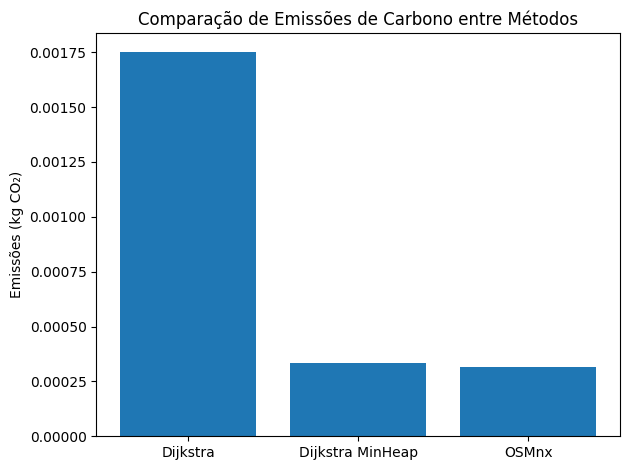

In [19]:
labels = ['Dijkstra', 'Dijkstra MinHeap', 'OSMnx']
values = [carb_dijkstra, carb_dijkstra_min_heap, carb_ox]
plt.figure()
plt.bar(labels, values)
plt.ylabel('Emissões (kg CO₂)')
plt.title('Comparação de Emissões de Carbono entre Métodos')
plt.tight_layout()
plt.show()

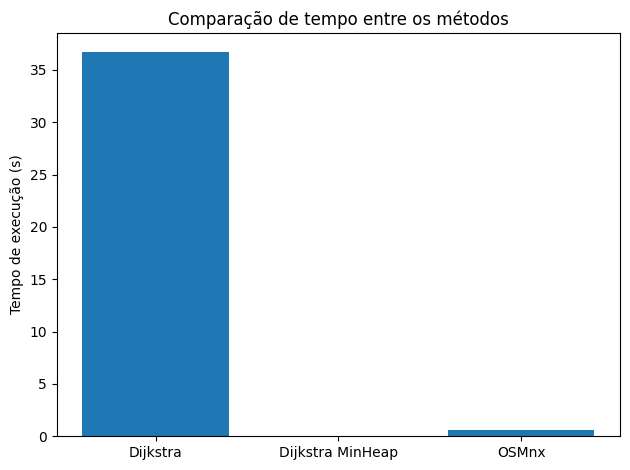

In [20]:
labels = ['Dijkstra', 'Dijkstra MinHeap', 'OSMnx']
values = [time_dijkstra, time_dijkstra_min_heap, time_ox]
plt.figure()
plt.bar(labels, values)
plt.ylabel('Tempo de execução (s)')
plt.title('Comparação de tempo entre os métodos')
plt.tight_layout()
plt.show()

In [ ]:
G_undirected = G.to_undirected()

In [ ]:
for component in nx.connected_components(G_undirected):
    print(component)